# Entry Level Exploration

Simple distributions over time, people and so on... Testing the infrastructure too!

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import dask
import dask_mongo
import dask.dataframe as dd

from langcodes import Language

In [2]:
sns.set_theme(style='darkgrid')

## Loading and preparing data from MongoDB

In [3]:
b = dask_mongo.read_mongo(
    database='tweets',
    collection='tweets',
    chunksize=1000,
    connection_kwargs={
        'host': 'localhost',
        'port': 27017,
        'username': 'admin',
        'password': 'pass'
    }
)

In [4]:
df = b.to_dataframe()

In [5]:
df.columns

Index(['_id', 'created_at', 'full_text', 'geo', 'id', 'lang', 'retweet_count'], dtype='object')

In [6]:
df.dtypes

_id              object
created_at       object
full_text        object
geo              object
id               object
lang             object
retweet_count     int64
dtype: object

In [7]:
df = df.astype({'lang': 'category'})
df['lang'].unique().compute()

0      en
1      ja
2      es
3      it
4      pl
     ... 
63     or
64     ps
65     si
66     ne
67    qct
Name: lang, Length: 68, dtype: category
Categories (68, object): ['ar', 'art', 'bg', 'cs', ..., 'ps', 'si', 'ne', 'qct']

In [8]:
df.dtypes

_id                object
created_at         object
full_text          object
geo                object
id                 object
lang             category
retweet_count       int64
dtype: object

In [144]:
df.describe().compute()

,retweet_count
count,406273.000000
mean,550.093705
std,2309.737132
min,0.000000
25%,5.000000
50%,114.000000
75%,1125.000000
max,137941.000000


In [145]:
df.head(10)

,_id,created_at,full_text,geo,id,lang,retweet_count
0,6412532d8b870b34420f01e1,Sat Sep 10 00:06:55 +0000 2022,The last 48 hours have seen quite a lot happen...,None,1568390526734598145,en,2295
1,6412532d8b870b34420f01e2,Sat Sep 10 00:02:45 +0000 2022,RT @jpg2t785: ハルキウでロシア軍のズーパルク-1M対砲兵レーダーが鹵獲されたと...,None,1568389478036963329,ja,220
2,6412532d8b870b34420f01e3,Sat Sep 10 00:06:05 +0000 2022,RT @Militarylandnet: 📽️Russian tank with infan...,None,1568390316763250688,en,357
3,6412532d8b870b34420f01e4,Sat Sep 10 00:00:28 +0000 2022,RT @lesiavasylenko: #Vysokopilya and #Balakliy...,None,1568388903626760193,en,94
4,6412532d8b870b34420f01e5,Sat Sep 10 00:02:06 +0000 2022,RT @TernovskyVictor: Quien es fascista es Jose...,None,1568389314228396032,es,270
5,6412532d8b870b34420f01e6,Sat Sep 10 00:01:32 +0000 2022,RT @gayit: Pussy Riot a https://t.co/r8kdZHkRc...,None,1568389171584110594,it,4
6,6412532d8b870b34420f01e7,Sat Sep 10 00:03:18 +0000 2022,Fix lighting levels above and below the world ...,None,1568389614477639680,en,0
7,6412532d8b870b34420f01e8,Sat Sep 10 00:06:12 +0000 2022,RT @Martinnkaaaa: #Ukraine #UkraineRussiaWar #...,None,1568390346962309123,pl,551
8,6412532d8b870b34420f01e9,Sat Sep 10 00:09:11 +0000 2022,RT @UAWeapons: #Ukraine: Ukrainian forces stru...,None,1568391098145587200,en,232
9,6412532d8b870b34420f01ea,Sat Sep 10 00:08:18 +0000 2022,RT @UAWeapons: #Ukraine: A Russian T-72B3 Obr....,None,1568390876396924929,en,551


In [9]:
# turning create_at to datetime
df['created_at'] = dd.to_datetime(df['created_at'], utc=True)

In [147]:
# setting index for datetime
# df = df.set_index('created_at')

## Geolocation data

In [60]:
df['geo'] = df['geo'].map(lambda x: pd.NA if x is None else x)

In [70]:
# FIXME we need to change `geo` column dictionaries
df['geo'][df['geo'].notnull()].count().compute()

TypeError: unhashable type: 'dict'

## Language Usage

In [10]:
lang_count = df['lang'].value_counts().compute()

In [11]:
lang_count

en     236385
fr      35712
de      32297
it      21066
ja       9637
        ...  
ne          7
ps          6
si          4
qct         3
ug          1
Name: lang, Length: 68, dtype: int64

In [12]:
lang_count = lang_count[lang_count > 1000]

In [13]:
def get_full_language_name(twitter_code: str):
    twitter_special_codes = {
        'qam': 'mentions only',
        'qct': 'cashtags only',
        'qht': 'hashtags only',
        'qme': 'media links only',
        'qst': 'very short text',
        'zxx': 'media or Twitter Card only'
    }
    return twitter_special_codes.get(twitter_code, Language.get(twitter_code).display_name())

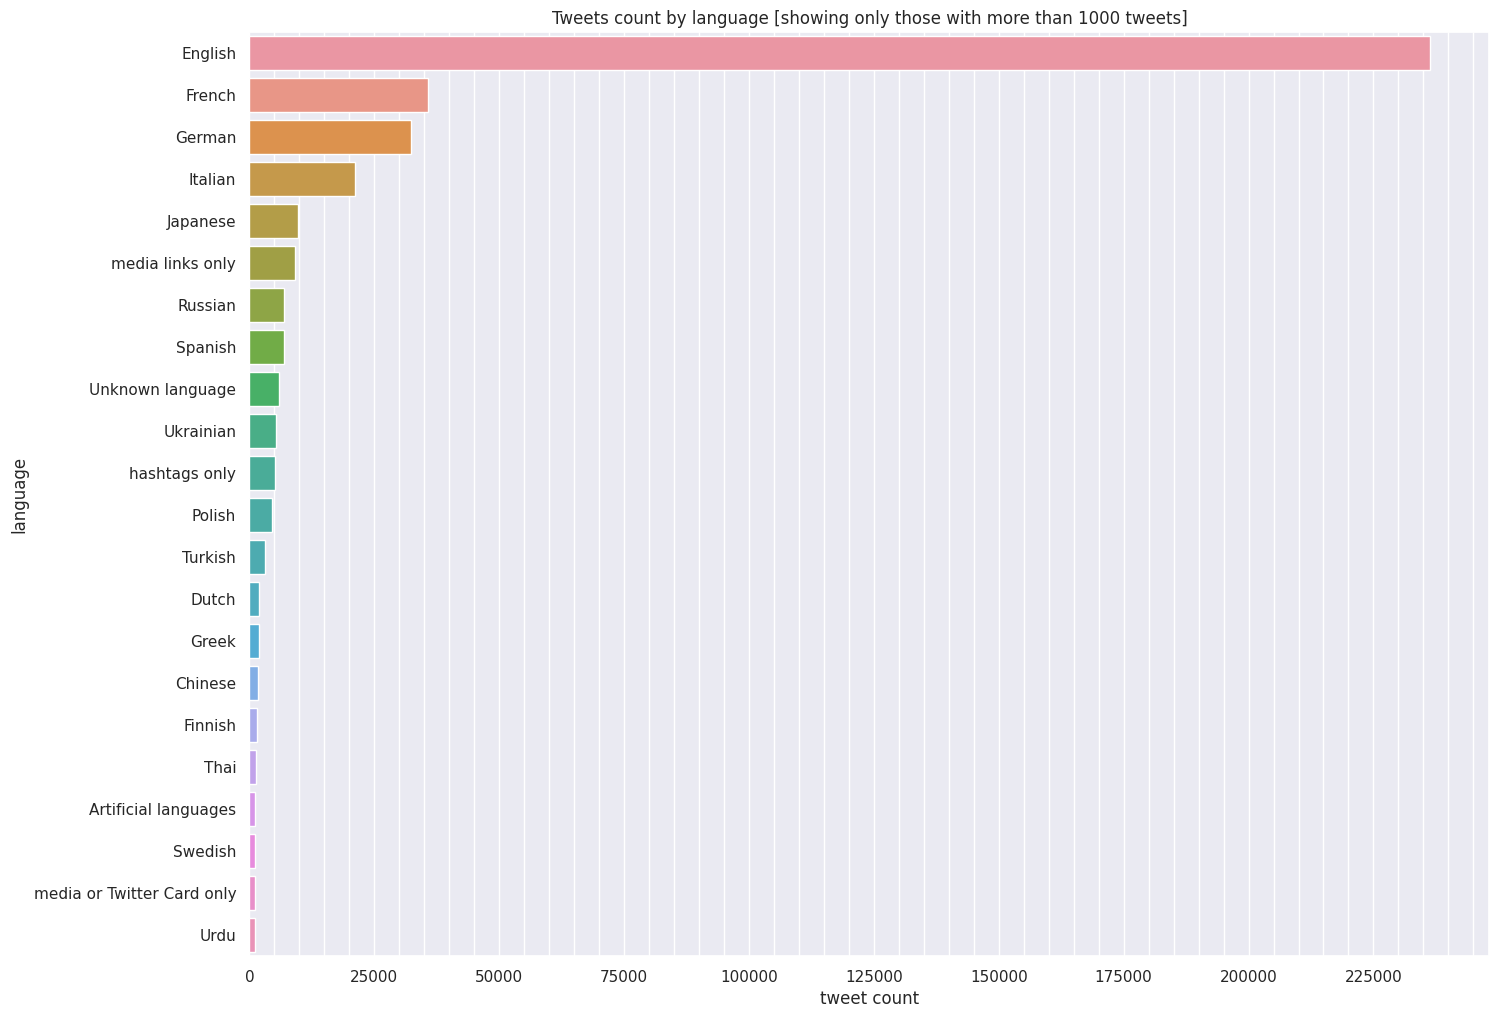

In [14]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.barplot(y=np.arange(len(lang_count)), x=lang_count, orient='h', ax=ax)

ax.set_title('Tweets count by language [showing only those with more than 1000 tweets]')

language_full_names = [get_full_language_name(code) for code in lang_count.index]
ax.set_yticks(np.arange(len(lang_count)), labels=language_full_names)
ax.set_xticks(np.arange(0, 250_000, 25000), minor=False)
ax.set_xticks(np.arange(0, 250_000, 5000), minor=True)

ax.set_xlabel('tweet count')
ax.set_ylabel('language')

ax.grid(visible=True, axis='x', which='both')
plt.show()

## Tweet Length Distribution

In [15]:
tweet_lengths = df['full_text'].map(len).value_counts().compute()

In [16]:
tweet_lengths

140    198548
139     32734
144     10310
143      2053
138      2035
        ...  
510         1
505         1
501         1
492         1
982         1
Name: full_text, Length: 546, dtype: int64

In [39]:
length_idxs = np.argsort(tweet_lengths.index.values)
x = tweet_lengths.index.values[length_idxs]
y = tweet_lengths.values[length_idxs]

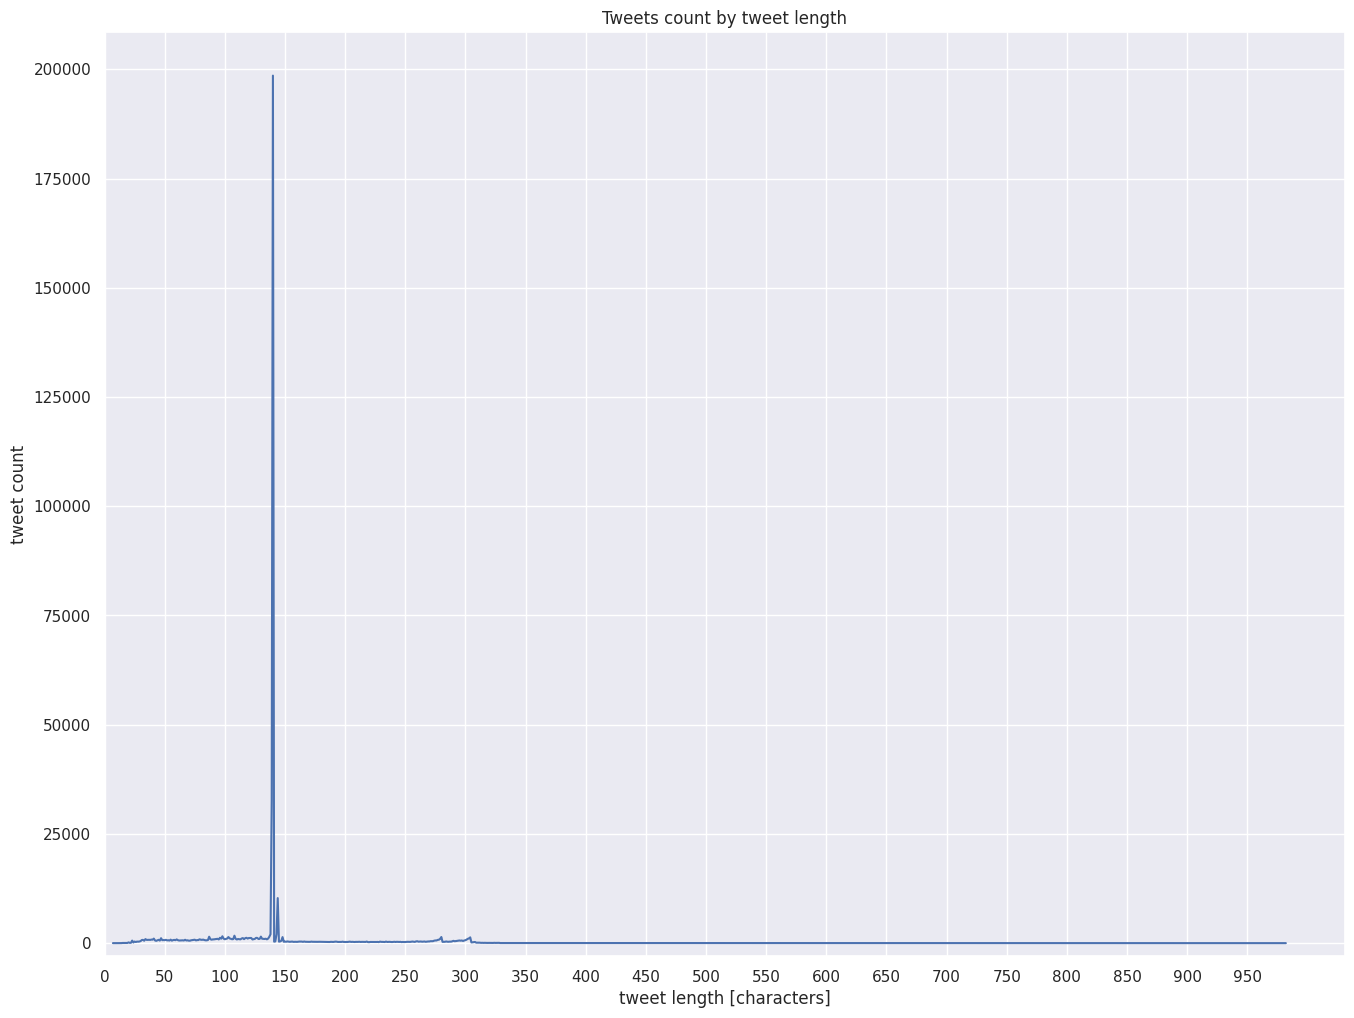

In [49]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(x, y)

ax.set_title('Tweets count by tweet length')

ax.set_xticks(np.arange(0, 1000, 50), minor=False)
ax.set_xlim(0)
ax.set_ylim(-3000)

ax.set_xlabel('tweet length [characters]')
ax.set_ylabel('tweet count')

plt.show()

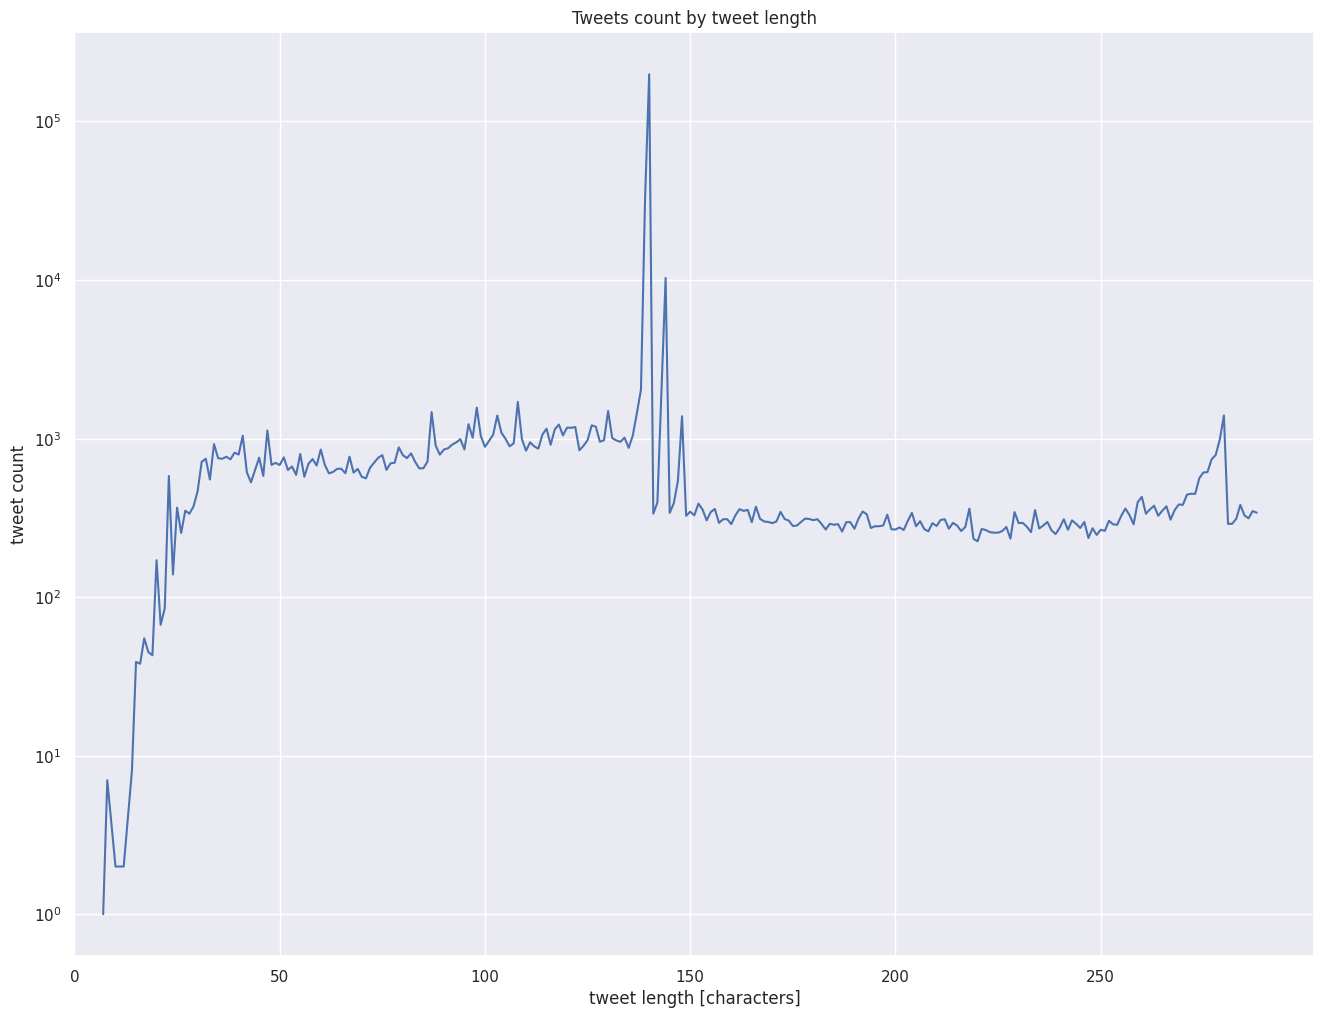

In [50]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(x[:280], y[:280])

ax.set_title('Tweets count by tweet length')
ax.set_yscale('log')

ax.set_xticks(np.arange(0, 300, 50), minor=False)
ax.set_xlim(0)

ax.set_xlabel('tweet length [characters]')
ax.set_ylabel('tweet count')

# ax.grid(visible=True, axis='y', which='both')
plt.show()

Maybe we need to process text first, remove everything, which does not have any value (links, hashtags, mentions, so on...)

## Tweet Length Distribution (simple tokenization)

In [94]:
def simple_token_count(text: str) -> int:
    return len(text.strip().split())

In [95]:
tweet_token_counts = df['full_text'].map(simple_token_count).value_counts().compute()

In [96]:
tweet_token_counts

21    42143
22    40622
20    35357
23    34443
19    26503
      ...  
69        1
74        1
79        1
78        1
99        1
Name: full_text, Length: 91, dtype: int64

In [97]:
token_counts_idxs = np.argsort(tweet_token_counts.index.values)
x = tweet_token_counts.index.values[token_counts_idxs]
y = tweet_token_counts.values[token_counts_idxs]

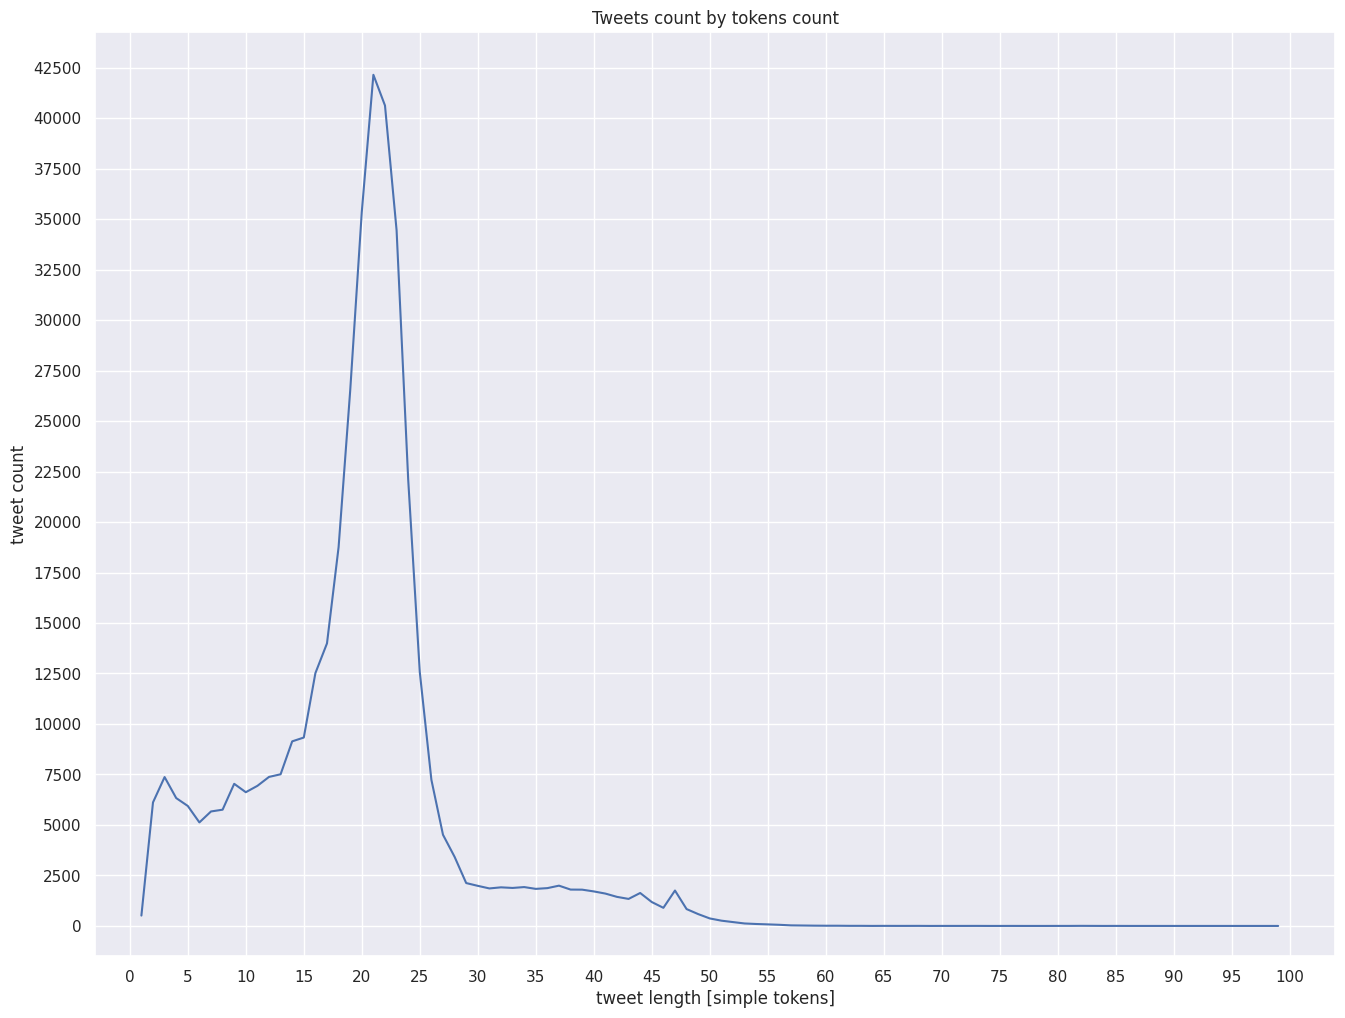

In [105]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(x, y)

ax.set_title('Tweets count by tokens count')

ax.set_xticks(np.arange(0, 105, 5), minor=False)
ax.set_yticks(np.arange(0, 45000, 2500), minor=False)

ax.set_xlim(-3)
ax.set_ylim(-1500)

ax.set_xlabel('tweet length [simple tokens]')
ax.set_ylabel('tweet count')

plt.show()

## Retweet Count Distribution

How popular/visible are the tweets we have collected?

In [51]:
retweet_counts = df['retweet_count'].value_counts().compute()

In [52]:
retweet_counts

0       83902
1       24345
2       13129
3        9201
4        7109
        ...  
556         1
1009        1
991         1
2648        1
1417        1
Name: retweet_count, Length: 1260, dtype: int64

In [53]:
retweets_idxs = np.argsort(retweet_counts.index.values)
x = retweet_counts.index.values[retweets_idxs]
y = retweet_counts.values[retweets_idxs]

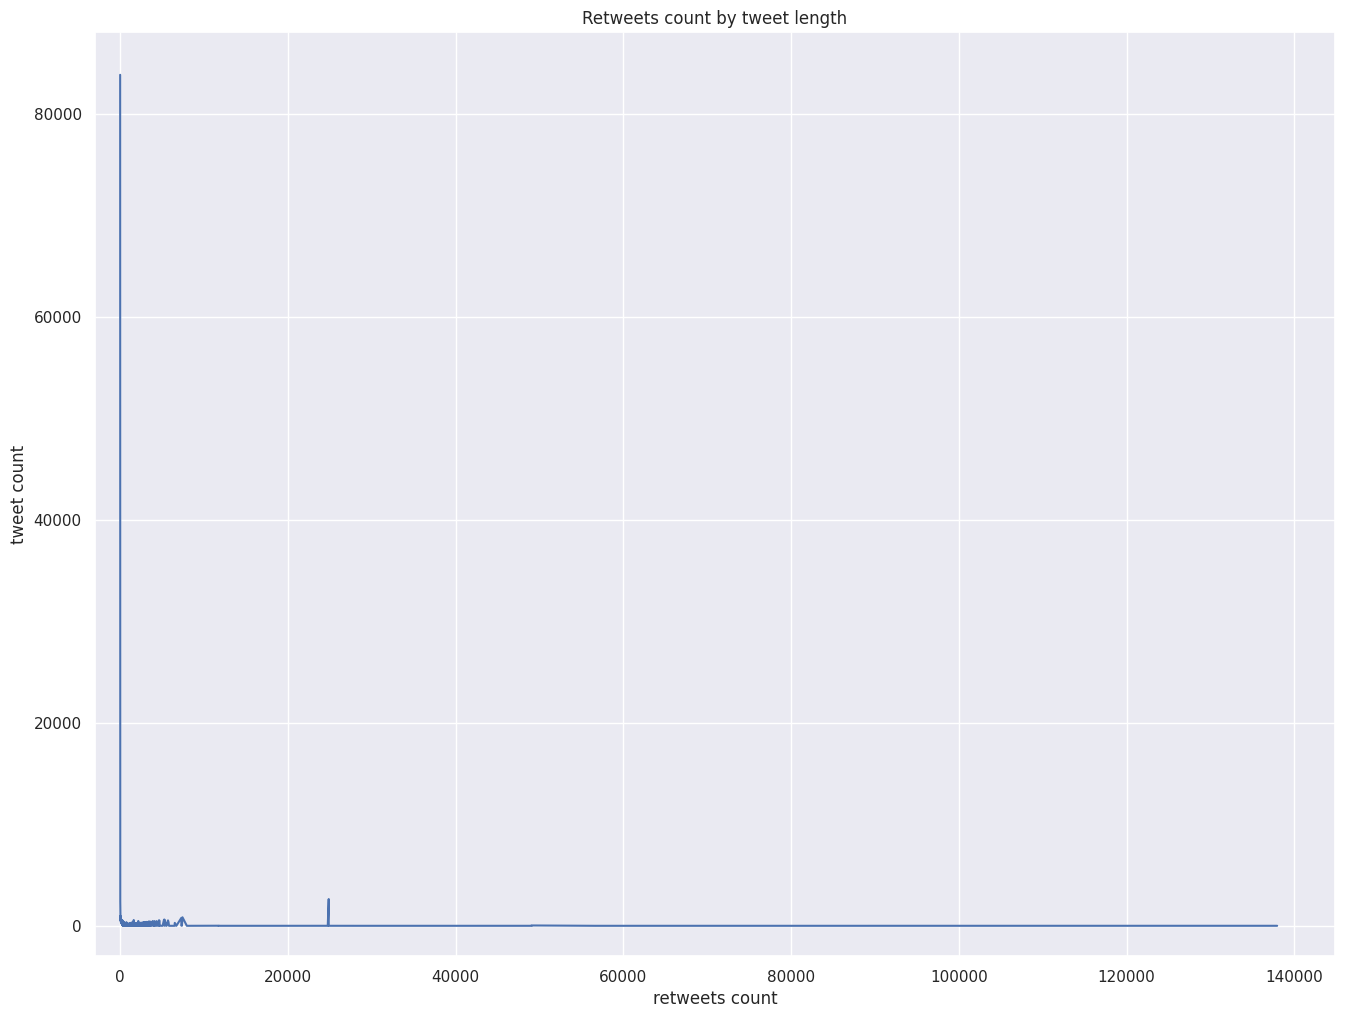

In [57]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(x, y)

ax.set_title('Retweets count by tweet length')

ax.set_xlim(-3000)
ax.set_ylim(-3000)

ax.set_xlabel('retweets count')
ax.set_ylabel('tweet count')

plt.show()

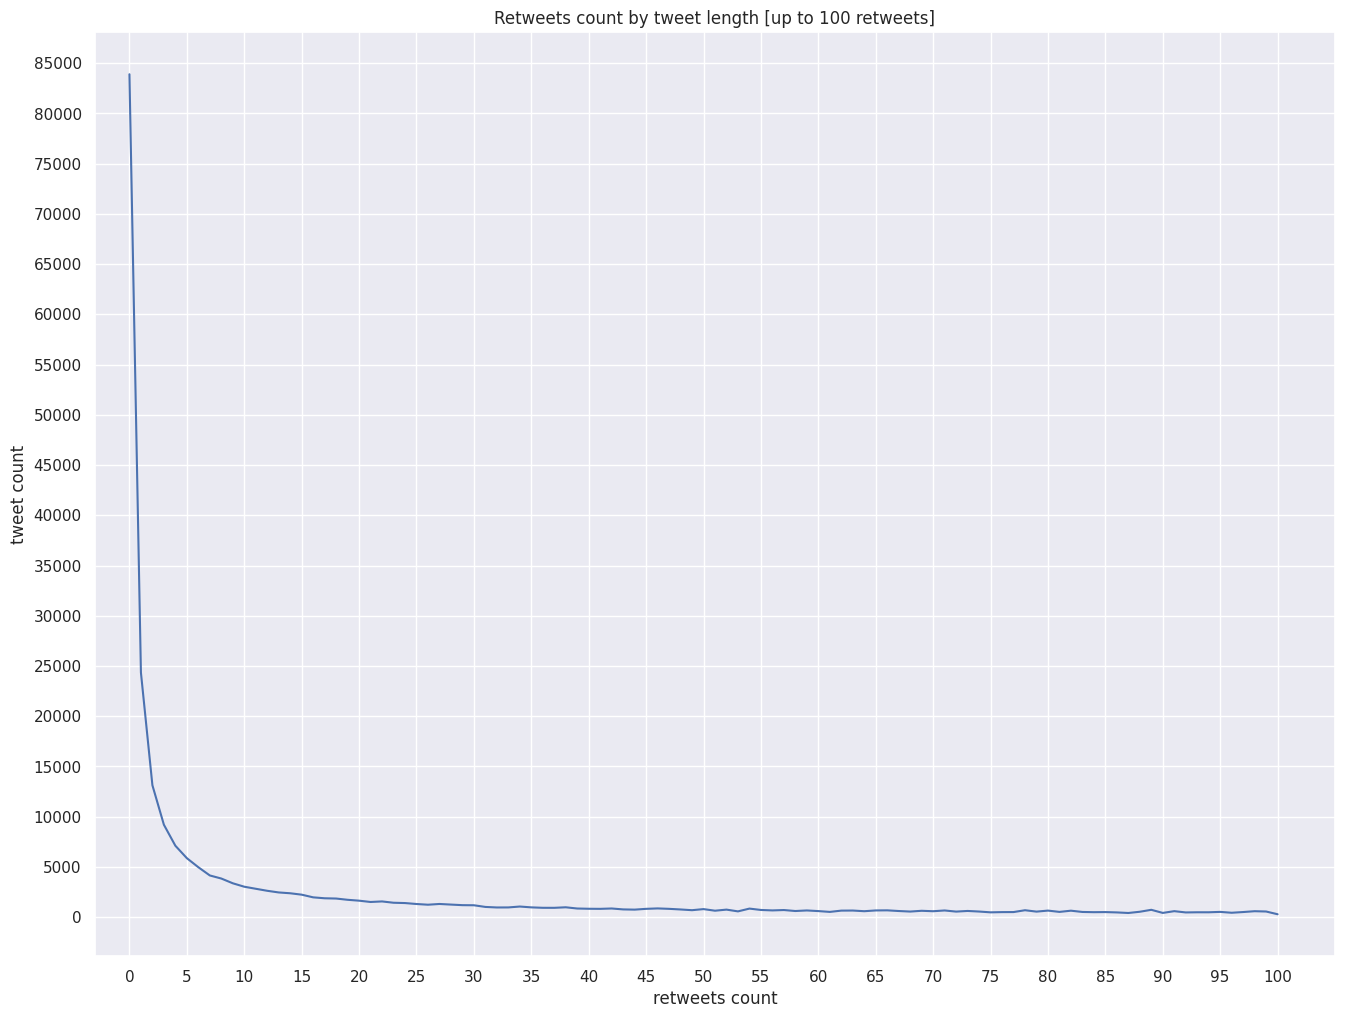

In [93]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(x[:101], y[:101])

ax.set_title('Retweets count by tweet length [up to 100 retweets]')

ax.set_xticks(np.arange(0, 105, 5), minor=False)
ax.set_yticks(np.arange(0, 90_000, 5000), minor=False)
ax.set_xlim(-3)

ax.set_xlabel('retweets count')
ax.set_ylabel('tweet count')

plt.show()